In [1]:
import sys, os, time
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train
#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data

np.set_printoptions(linewidth=120, suppress=True)

In [2]:
90797 / 96000

0.9458020833333334

In [3]:
363283 / (480000-96000)

0.9460494791666667

In [7]:
dataset = train.get_dataset('cr-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], train=True)
len(dataset)

363283

In [2]:
dataset = train.get_dataset('3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'], labels=True)
len(dataset)

384000

In [3]:
dataset = train.get_dataset('redcap-3dshapes', dataroot=os.environ['FOUNDATION_DATA_DIR'])
len(dataset)

363283

In [3]:
dataset.factor_order

['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']

In [4]:
# i = -1

<IPython.core.display.Javascript object>


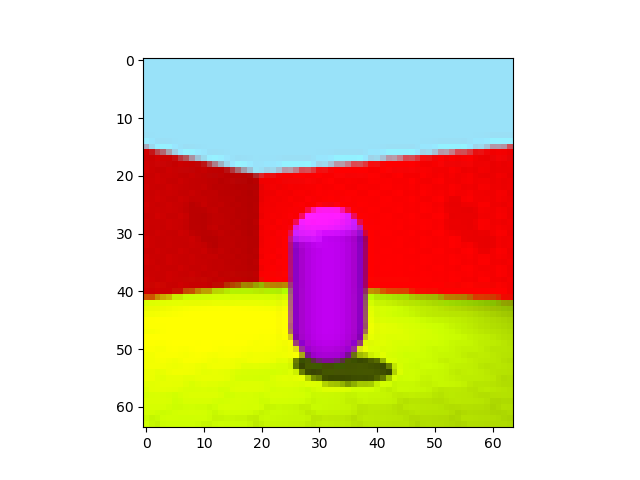

In [32]:
# i += 1
i = np.random.randint(len(dataset))
x, = dataset[i]
plt.imshow(x.permute(1,2,0).numpy())

In [10]:
y

tensor([ 0.2000,  0.4000,  0.9000,  0.8929,  3.0000, -8.5714])

In [3]:
dataset = train.get_dataset('z-celeba', dataroot=os.environ['FOUNDATION_DATA_DIR'], label_type='attr')

NameError: name 'train' is not defined

In [ ]:
i = np.random.randint(len(dataset))

In [ ]:
x, y = dataset[i]
x.shape, y.shape

In [ ]:
plt.imshow(x.permute(1,2,0).numpy())